# Functions

In [1]:
def get_words(line):
    r'''
    This function takes a text and returns
    a list of lowercase words. It removes all digits
    and strips punctuation characters from the words.
    
    >>> get_words('Here are severall1000 words!\n Blub')
    ['here', 'are', 'severall', 'words', 'blub']
    
    >>> get_words('"Where are they? 10 \t 1000!?"')
    ['where', 'are', 'they']
    
    >>> get_words('\t\t\t\r\r\r\n<ada> hallo12 \r\t\t\t\t')
    ['ada', 'hallo']
    
    '''
    import re
    line = re.sub('\s*[\r\t]+','',line)
    line = re.sub('[^a-zA-Z\s\'-]+','',line)
    line = line.lower()
    
    words = line.split()
    return words

if __name__ == '__main__':
    import doctest
    doctest.testmod()

# Data Import

In [2]:
import pandas as pd
import json
from collections import Counter

# Columns which shall be kept from the downloaded data
columns = ['job_title', 'employer', 'origin', 'location',
           'salary', 'job_type', 'job_description',]

# Keywords to check for in the job description. Each keyword 
# gets its own column with True and False values.
keywords = ['python', 'java', 'perl', 'r', 'fortran', 'sql',
            'html', 'css', 'javascript', 'c', 'c++', 'c#',
            'bioinformatician', 'bioinformatics',
            'researcher', 'details', 'skills', 'successful'
            'program', 'expected', 'strong']

# load nature jobs
with open('jobspiders/nature_jobs.json', 'r') as myfile:
    nature_jobs = json.load(myfile)

# load science jobs
with open('jobspiders/science_jobs.json', 'r') as myfile:
    science_jobs = json.load(myfile)

# Count words and add an orign entry to the science data
for entry in science_jobs:
    entry['job_description_words'] = Counter(get_words(entry['job_description']))
    entry['origin'] = 'science'

# Count words and add an orign entry to the nature data
for entry in nature_jobs:
    entry['job_description_words'] = Counter(get_words(entry['job_description']))
    entry['origin'] = 'nature'

# Combine the job data from science and nature
job_data = science_jobs+nature_jobs

# Add the entries for the keywords
for entry in job_data:
    for keyword in keywords:
        if keyword in entry['job_description_words'].keys():
            entry[keyword] = entry['job_description_words'][keyword]
        else:
            entry[keyword] = 0

# Read the data into a dataframe and select the specified columns
df = pd.DataFrame(job_data)
df = df[columns+keywords]

# Inspect data

## Remove duplicates

Here we remove duplicates by two different approaches. First we remove all rows from our pandas DataFrame which are not unique. A row is unique if there is no other row which has the same values in every column. 

In [3]:
print(len(df[df.duplicated()==True]))
df = df[df.duplicated()==False]

33


There are still multiple rows which have the same job_title and employer combination as one can see here.

In [4]:
print(len(df[df.duplicated(subset=['job_title', 'employer',
                                   ])==True]))

90


We want to exclude entries if they were just reposted or posted accidentially twice. We also want to exclude job ads which are for the same position but posted on different platforms with minor differences. Therefore we decided to use the counts of keywords which appear in the job description in addition to the job title and the employer.

In [5]:
print(len(df[df.duplicated(subset=['job_title', 'employer']+
                                     keywords)==True]))

df = df[df.duplicated(subset=['job_title', 'employer']+
                              keywords)==False]

47


Our DataFrame has now 3029 rows, while 1095 originate from the Science Careers and 1934 from Nature Jobs. For Science Careers only job offers from the life science were included while there was no pre selection for Nature Jobs

In [6]:
print(len(df))
print(len(df[df['origin']=='science']))
print(len(df[df['origin']=='nature']))

3029
1095
1934


In [7]:
print(len(df[(df['job_type']=='Bioinformatics') |
              (df['job_type']=='Bioinformatician')]))

print(len(df[(df['bioinformatics']>0) |
             (df['bioinformatician']>0) |
             (df['job_type']=='Bioinformatics') |
             (df['job_type']=='Bioinformatician')]))

24
383


In [8]:
x = df[(df['bioinformatics']>0) |
              (df['bioinformatician']>0)]

print(len(x[(x['job_type']=='Bioinformatics') |
              (x['job_type']=='Bioinformatician')]))

21


In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


In [10]:
df.columns.values

array(['job_title', 'employer', 'origin', 'location', 'salary', 'job_type',
       'job_description', 'python', 'java', 'perl', 'r', 'fortran', 'sql',
       'html', 'css', 'javascript', 'c', 'c++', 'c#', 'bioinformatician',
       'bioinformatics', 'researcher', 'details', 'skills',
       'successfulprogram', 'expected', 'strong'], dtype=object)

In [11]:
len(df[df.duplicated(subset=['job_title', 'employer', 'salary'])==True])

41

# Question 1: Which programming languages are mentioned most in job ads for bioinformaticians?

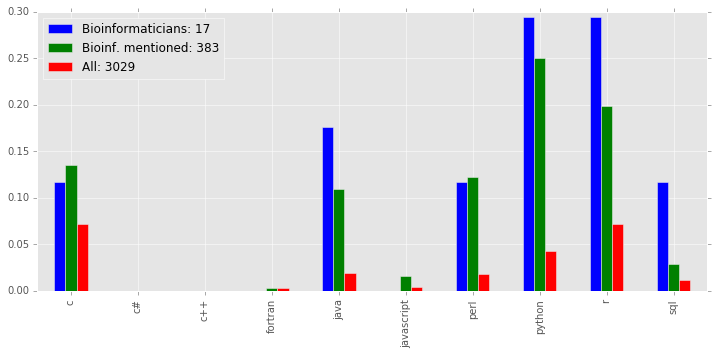

In [12]:
bioinformatician = df.loc[df['job_type'] == 'Bioinformatician']
bio = bioinformatician[['java', 'python', 'perl', 'r', 
                        'fortran','sql', 'javascript', 'c++', 'c', 'c#']]

mentioned_bioinf = df[(df['bioinformatics']>0) |
                      (df['bioinformatician']>0) |
                      (df['job_type']=='Bioinformatics') |
                      (df['job_type']=='Bioinformatician')]
mentioned_bioinf = mentioned_bioinf[['java', 'python', 'perl', 'r', 
                        'fortran','sql', 'javascript', 'c++', 'c', 'c#']]

#print(bioinformatician.ix[262][['job_description']])
#print(bioinformatician.loc[26, 'job_description'])

all_jobs = df[['java', 'python', 'perl', 'r', 
               'fortran', 'javascript', 'c++', 'c', 'c#','sql']]

plotframe = pd.concat([bio.sum()/len(bio),
                       mentioned_bioinf.sum()/len(mentioned_bioinf),
                       all_jobs.sum()/len(all_jobs)], axis=1)

plotframe.set_index(bio.sum().index)
plotframe = plotframe.rename(index = str, columns={0:'Bioinformaticians: '+str(len(bio)),
                                                   1:'Bioinf. mentioned: '+str(len(mentioned_bioinf)),
                                                   2:'All: '+str(len(all_jobs))})
ax = plotframe.plot(kind='bar', figsize=(12, 5))



# Programming in Biology

# Which languages are mentioned together

In [13]:
len(df[(df['java'] > 0) & (df['python'] > 0)])

43